In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss
import matplotlib.pyplot as plt

In [18]:
# Load the dataset
df = pd.read_csv("data/diabetic_data.csv")

# Replace '?' with NaN
df = df.replace('?', np.nan)

# Keep only <30 and >30 for readmission
df = df[df['readmitted'].isin(['<30', '>30'])]

# Drop columns with more than 40% missing data
missing_threshold = 0.4
df = df.loc[:, df.isnull().mean() < missing_threshold]

# Drop rows with missing values **only in the remaining columns**
df = df.dropna()

# Drop identifiers
df = df.drop(['encounter_id', 'patient_nbr'], axis=1, errors='ignore')

# One-hot encode categorical features
categorical_cols = df.select_dtypes(include='object').columns.drop('readmitted')
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Binary target: 1 if readmitted within 30 days
df['readmitted'] = (df['readmitted'] == '<30').astype(int)

print(f"Dataset shape after cleaning: {df.shape}")


Dataset shape after cleaning: (27672, 1759)


In [19]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"]
y

23668     1
23871     0
24028     0
24039     1
24090     0
         ..
101750    1
101755    0
101756    0
101760    0
101761    0
Name: readmitted, Length: 27672, dtype: int64

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [36]:
rf = RandomForestClassifier(
        n_estimators=1000,
        max_depth=10,
        min_samples_split=50,
        min_samples_leaf=20,
        max_features="sqrt",
        class_weight={0: 1, 1: 4} ,
        random_state=42
    )

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 4}, max_depth=10,
                       min_samples_leaf=20, min_samples_split=50,
                       n_estimators=1000, random_state=42)

In [33]:
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)  

# print(confusion_matrix(y_test, y_pred_train))
# print(classification_report(y_test, y_pred_train))

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.6568921011874032
Test Accuracy: 0.6320163815947965


In [34]:
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

print("=======================================")

print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

[[10416  4394]
 [ 2252  2308]]
              precision    recall  f1-score   support

           0       0.82      0.70      0.76     14810
           1       0.34      0.51      0.41      4560

    accuracy                           0.66     19370
   macro avg       0.58      0.60      0.58     19370
weighted avg       0.71      0.66      0.68     19370

[[4358 1990]
 [1065  889]]
              precision    recall  f1-score   support

           0       0.80      0.69      0.74      6348
           1       0.31      0.45      0.37      1954

    accuracy                           0.63      8302
   macro avg       0.56      0.57      0.55      8302
weighted avg       0.69      0.63      0.65      8302



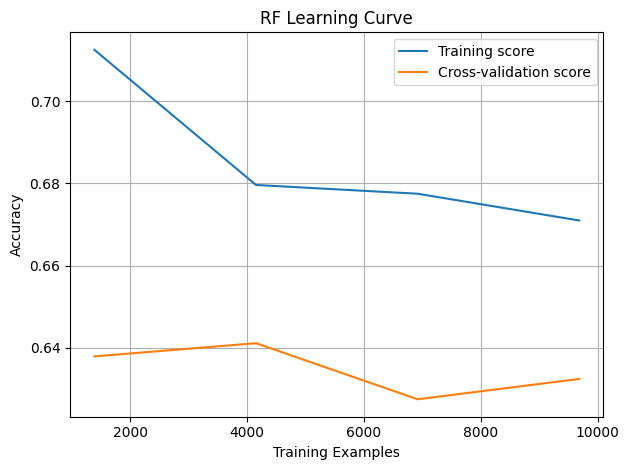

In [35]:
train_sizes, train_scores, test_scores = learning_curve(
    rf, X, y, 
    cv=2,  # Minimal CV folds
    scoring='accuracy', 
    train_sizes=[0.1, 0.3, 0.5, 0.7],  # Fewer, specific sizes
    n_jobs=1  # Single core
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score")
plt.title("RF Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.tight_layout()
plt.show()